# Visualizing fire scars through false color

### Data Source Descriptions:

- #### Landsat 8 Raster Image
This raster image comprises of a collection of bands from Landsat Collection 2 Level-2 Science Products. The data consists of atmospherically corrected surface reflectance and surface temperature image data. This raster image has been clipped to the extent surrounding the Palisades and Eaton fires. The image used in this analysis was collected through the Landsat 8 satellite.

Source link: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2#overview

Source Date: 02/23/2025

Date of Access: 11/19/2025

- #### CA Perimeters CAL FIRE NIFC FIRIS
The following data source was obtained from the California Natural Resources Agency. The dataset is a shapefile which includes a layer encompassing three feature layers for CAL FIRE's public incident map. The data itself is sourced from the CAL Fire's Intel Remote Sensing Data, FIRIS wildire perimeters, and NIFC's WFIGS 2024 Interagency Fire Perimeters to Date.

Source link: https://gis.data.cnra.ca.gov/datasets/CALFIRE-Forestry::ca-perimeters-cal-fire-nifc-firis-public-view/about

Source Date: 01/30/2024

Date of Access: 11/19/2025

In [ ]:
# Import libraries
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import netCDF4
import rioxarray as rio


#### 2. Fire perimeter data exploration


In [28]:
# Create file path for fire perimeter data
fp = os.path.join('data','CA_Perimeters_CAL_FIRE_NIFC_FIRIS_public_view','CA_Perimeters_CAL_FIRE_NIFC_FIRIS_public_view.shp')

# View file path
fp

# Read in fire perimeter data
fire_perimeter = gpd.read_file(fp)

# View the first five rows of the `fire_perimeter` shapefile
fire_perimeter.head()


,OBJECTID,GlobalID,type,source,poly_DateC,mission,incident_n,incident_1,area_acres,descriptio,FireDiscov,CreationDa,EditDate,displaySta,geometry
0,3025,04ba1d01-c043-478f-ad62-e7eeb903cf09,Heat Perimeter,FIRIS,2025-01-01,CA-SBC-OAK-N40Y,Oak,None,41.998143,FIRIS Perimeter,None,2025-01-01,None,Inactive,"POLYGON ((-13385394.472 4148110.966, -13385391..."
1,3026,4551a5e4-e94d-46e2-9aac-73cc4314c946,Heat Perimeter,FIRIS,2025-01-02,CA-SDU-BORDER1-N40Y,None,None,16.911501,FIRIS Perimeter,None,2025-01-02,None,Inactive,"MULTIPOLYGON (((-13005375.821 3841915.091, -13..."
2,3027,2b1329f3-5b39-4c0e-ad34-1250e436e0e1,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,771.572356,FIRIS Perimeter,None,2025-01-07,None,Inactive,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."
3,3028,a766c1b5-1d8e-43b3-9aac-02358de18d35,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,1261.520779,FIRIS Perimeter,None,2025-01-07,None,Inactive,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."
4,3029,72049d43-03fe-4cc1-899a-fe2eb43934e7,Heat Perimeter,FIRIS,2025-01-07,CA-LFD-PALISADES-N57B,None,None,1261.520779,FIRIS Perimeter,None,2025-01-07,None,Inactive,"MULTIPOLYGON (((-13196940.578 4037122.987, -13..."


In [ ]:
# Check the data type of the fire perimeter geodataframe 
print(type(fire_perimeter))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [30]:
# Check the data type of the geometry column
print(type(fire_perimeter.geometry))

<class 'geopandas.geoseries.GeoSeries'>


In [31]:
# Check the data type of each column
fire_perimeter.dtypes

OBJECTID         int64
GlobalID        object
type            object
source          object
poly_DateC      object
mission         object
incident_n      object
incident_1      object
area_acres     float64
descriptio      object
FireDiscov      object
CreationDa      object
EditDate        object
displaySta      object
geometry      geometry
dtype: object

In [ ]:
# Check the dimensions of the geodataframe
fire_perimeter.shape

(710, 15)

In [ ]:
# Check the type of each element in the geometry column
fire_perimeter.geom_type

0           Polygon
1      MultiPolygon
2      MultiPolygon
3      MultiPolygon
4      MultiPolygon
           ...     
705    MultiPolygon
706    MultiPolygon
707         Polygon
708    MultiPolygon
709         Polygon
Length: 710, dtype: object

In [33]:
# Access the CRS of the GeoDataFrame
fire_perimeter.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
# Examine CRS details
print('Ellipsoid: ', fire_perimeter.crs.ellipsoid)
print('Datum: ', fire_perimeter.crs.datum)
print('Is geographic?: ', fire_perimeter.crs.is_geographic)
print('Is projected?: ', fire_perimeter.crs.is_projected)

Ellipsoid:  WGS 84
Datum:  World Geodetic System 1984 ensemble
Is geographic?:  False
Is projected?:  True


In [35]:
# Obtain the geographic extent of the geo-dataframe
fire_perimeter.total_bounds

array([-13778224.4372768 ,   3836652.57617612, -12755316.1134977 ,
         5228676.76990464])

In [44]:
# Create function that checks the geometry types of the of the dataframe
def check_polygons(gdf):
    geometry_types = gdf.geometry.geom_type.unique()
    
    if len(geometry_types) == 1:
        print(f"All features are: {geometry_types[0]}")
    else:
        print(f"Multiple feature types: {', '.join(geometry_types)}")

In [45]:
# Check the geometry types of the dataframe
check_polygons(fire_perimeter)

Multiple feature types: Polygon, MultiPolygon


<Axes: >

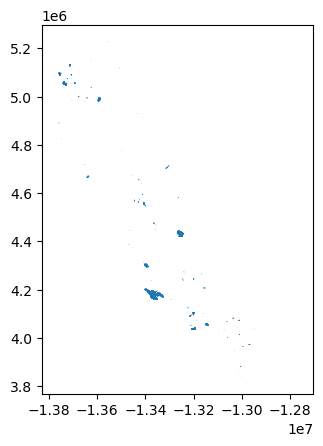

In [36]:
# Take a look at the `fire_perimeter` data
fire_perimeter.plot()

#### Summary of Preliminary Data Exploration for Fire Perimeters GeoDataFrame
The `fire_perimeter` dataset is a  `geopandas.geodataframe`. The geodataframe has multiple feature types (Polygon and Multipolygon). It has a projected CRS of EPSG:3857. The units of the coordinates are in meters. The data types of each column are: string (object), integer (int64), floating decimal numbers (float64), for the acreage of  each fire perimeter, and geometry. The dimensions of the geodataframe are 710 rows and 15 columns. The total bounds of the geodataframe are -13778224.4372768 , 3836652.57617612, -12755316.1134977 , 5228676.76990464. Finally,the 

### 3. NetCDF data import and exploration

In [2]:
# Read in Landsat 8 data
landsat8 = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

In [18]:
# Check the x-axis of the array
landsat8.x

<xarray.DataArray 'x' (x: 2742)> Size: 22kB
array([334410., 334440., 334470., ..., 416580., 416610., 416640.])
Coordinates:
  * x        (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time     datetime64[ns] 8B ...
Attributes:
    units:          metre
    resolution:     30.0
    crs:            EPSG:32611
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate

In [ ]:
# Check the y-axis of the array
landsat8.y

<xarray.DataArray 'y' (y: 1418)> Size: 11kB
array([3799050., 3799020., 3798990., ..., 3756600., 3756570., 3756540.])
Coordinates:
  * y        (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
    time     datetime64[ns] 8B ...
Attributes:
    units:          metre
    resolution:     -30.0
    crs:            EPSG:32611
    axis:           Y
    long_name:      y coordinate of projection
    standard_name:  projection_y_coordinate

In [ ]:
# View the variables of the dataset
landsat8.variables

Frozen({'y': <xarray.IndexVariable 'y' (y: 1418)> Size: 11kB
array([3799050., 3799020., 3798990., ..., 3756600., 3756570., 3756540.])
Attributes:
    units:          metre
    resolution:     -30.0
    crs:            EPSG:32611
    axis:           Y
    long_name:      y coordinate of projection
    standard_name:  projection_y_coordinate, 'x': <xarray.IndexVariable 'x' (x: 2742)> Size: 22kB
array([334410., 334440., 334470., ..., 416580., 416610., 416640.])
Attributes:
    units:          metre
    resolution:     30.0
    crs:            EPSG:32611
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate, 'time': <xarray.Variable ()> Size: 8B
[1 values with dtype=datetime64[ns]], 'red': <xarray.Variable (y: 1418, x: 2742)> Size: 16MB
[3888156 values with dtype=float32]
Attributes:
    grid_mapping:  spatial_ref, 'green': <xarray.Variable (y: 1418, x: 2742)> Size: 16MB
[3888156 values with dtype=float32]
Attributes:
    grid_mapp

In [ ]:
# View a summary of information about `landsat8`
landsat8.info

<bound method Dataset.info of <xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...>

In [ ]:
# Check the class of the dataset
landsat8.__class__

xarray.core.dataset.Dataset

In [ ]:
# Check the contents of the dataset
landsat8.__contains__

<bound method Dataset.__contains__ of <xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...
    spatial_ref  int64 8B ...>

In [ ]:
# Check the data types of the variables within `landsat8`
landsat8.dtypes

Frozen({'red': dtype('float32'), 'green': dtype('float32'), 'blue': dtype('float32'), 'nir08': dtype('float32'), 'swir22': dtype('float32'), 'spatial_ref': dtype('int64')})

In [ ]:
# Check the dimensions of the dataset
landsat8.dims

FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

In [ ]:
# View the number of missing values within the dataset
landsat8.isnull().sum()

<xarray.Dataset> Size: 32B
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 8B ...
Data variables:
    red          int32 4B 0
    green        int32 4B 1
    blue         int32 4B 109
    nir08        int32 4B 0
    swir22       int32 4B 0
    spatial_ref  int32 4B 0

#### Summary of Preliminary Exploration for `landsat8`
> The blue band variable has 109 missing values while the green band has only one missing variable. The rest of the variables don't have missing values. The dimensions of the data set are 1418 'y-coordinates and 2742 x-coordinates. The data types of the bands are integers while the time variable is in datetime format. The units of measurement for the variables are in meter. The CRS is EPSG:32611. 

#### Restoring Geospatial Information


In [26]:
landsat8.rio.crs